# Notebook for performing data cleaning on the dataset
## Import libraries

In [9]:
import pandas as pd
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
import jellyfish

In [10]:
df_data_analyst = pd.read_csv("DataAnalyst.csv").drop(columns=['Unnamed: 0'])
df_data_analyst["data_title"] = "Data Analyst"
df_data_engineer = pd.read_csv("DataEngineer.csv")
df_data_engineer["data_title"] = "Data Engineer"
df_data_scientist = pd.read_csv("DataScientist.csv").drop(columns=['Unnamed: 0','index'])
df_data_scientist["data_title"] = "Data Scientist"
df_business_analyst = pd.read_csv("BusinessAnalyst.csv").drop(columns=['Unnamed: 0','index'])
df_business_analyst["data_title"] = "Business Analyst"
# Business analyst data from row 3692 is in wrong order. For now, drop the rows after that.
df_business_analyst = df_business_analyst.iloc[0:3691]
# df_data_analyst.append(df_data_engineer).append(df_data_scientist).append().append().append()
df = pd.concat([df_data_analyst, df_data_engineer, df_data_scientist, df_business_analyst], ignore_index=True)
print(df.shape)
df.tail()

(12381, 16)


,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply,data_title
12376,Urgent - Business Analyst (Information Technol...,$58K-$103K (Glassdoor est.),Job Description\nAbout us:\n\nStaffigo is in t...,5.0,"Staffigo Technical Services, LLC\n5.0","Austin, TX","Woodridge, IL",51 to 200 employees,2008,Company - Private,IT Services,Information Technology,$50 to $100 million (USD),-1,-1,Business Analyst
12377,Pega Business Analyst,$58K-$103K (Glassdoor est.),• 5 yrs relevant experience in:- Experience wi...,3.1,Tista Science and Technology Corporation\n3.1,"Austin, TX","Rockville, MD",501 to 1000 employees,2005,Company - Private,Consulting,Business Services,$5 to $10 million (USD),-1,-1,Business Analyst
12378,Jr.Business Analyst,$58K-$103K (Glassdoor est.),Job Description\n\nNew businesses are making t...,5.0,"Staffigo Technical Services, LLC\n5.0","Austin, TX","Woodridge, IL",51 to 200 employees,2008,Company - Private,IT Services,Information Technology,$50 to $100 million (USD),-1,-1,Business Analyst
12379,Business Process Analyst/Remote 4 mth+ contract,$58K-$103K (Glassdoor est.),Title: Business Process Analyst\nDuration: 4+ ...,-1.0,"Suncap Technology, Inc.","Austin, TX",-1,-1,-1,-1,-1,-1,-1,-1,-1,Business Analyst
12380,"AVP, Business System",$58K-$103K (Glassdoor est.),We are looking for a AVP Business System Analy...,3.5,LPL Financial\n3.5,"Austin, TX","Boston, MA",1001 to 5000 employees,1968,Company - Public,Investment Banking & Asset Management,Finance,$2 to $5 billion (USD),"Fidelity Investments, UBS, Morgan Stanley",-1,Business Analyst


## Inspect the data and clean missing or flawed values

In [11]:
# Drop columns that are not used in this analysis
df = df.drop(columns=["Competitors","Easy Apply","Founded"])
df = df.replace(-1,np.nan).replace(-1.0,np.nan).replace('-1',np.nan).replace('-1.0')
# # df = df.dropna() # Drop all nan values for now as imputing categorical values is quite bad for our case
# # Set missing values to "No value" or np.nan
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = [c for c in df.columns if c not in numeric_features]

for col in df.columns:
    if col in numeric_features:
        df[col] = df[col].fillna(df[col].mean())
    elif col in categorical_features:
        df[col] = df[col].fillna("No "+ col)

# Drop row if no salary estimate (target)
df = df[df["Salary Estimate"]!="No Salary Estimate"]



Usually the job title is in the form of "Actual title, something else, more info". Thus, we can probably just take the first words before the first comma, or other special character to make the job titles more coherent.


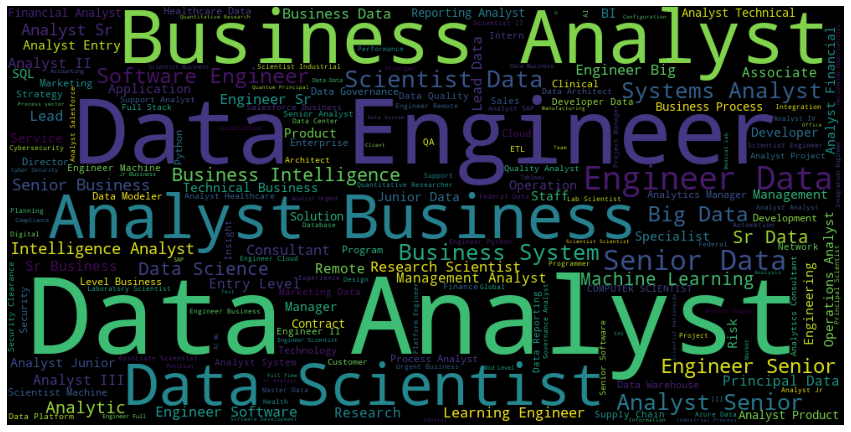

In [12]:
unique_string=(" ").join(df["Job Title"])
wordcloud_ = wordcloud.WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud_)
plt.axis("off")
plt.show()


In [13]:
# Top 50 titles from the wordcloud.
new_title_scores = pd.DataFrame.from_dict(wordcloud_.words_.items())
new_title_scores.head(5)

,0,1
0,Data Analyst,1.000000
1,Data Engineer,0.708907
2,Business Analyst,0.630702
3,Analyst Business,0.422520
4,Data Scientist,0.373642


Now, lets give each job title the most similar string from the wordcloud using Damerau-Levenshtein distance.

In [14]:
def find_most_similar(text,new_titles_list):
    sims = [jellyfish.damerau_levenshtein_distance(text,x) for x in new_titles_list]
    return new_titles_list[sims.index(min(sims))]


In [15]:
df["new_title"] = df["Job Title"].apply(lambda x: find_most_similar(x,new_title_scores[0]))

C:\Users\johma\AppData\Local\Temp/ipykernel_12432/348319044.py:2: DeprecationWarning: getargs: The 'u' format is deprecated. Use 'U' instead.
  sims = [jellyfish.damerau_levenshtein_distance(text,x) for x in new_titles_list]


In [16]:
df["new_title"].value_counts().head(5)

Business Analyst     2144
Data Engineer        1882
Data Analyst         1715
Data Scientist        723
Software Engineer     473
Name: new_title, dtype: int64

### The "new_title" might be used in the future, but we can also use the "data_title", which is given from each of the separate data csv's.

In [17]:
# Remove the "Glassdoor" and per hour from salary range
df["Salary Estimate"] = df["Salary Estimate"].apply(lambda s: s.replace("(Glassdoor est.)","").strip())
df = df[df["Salary Estimate"].str.contains("est")==False].copy()
df = df[df["Salary Estimate"].str.contains("Hour")==False].copy()
# Remove the "\n" from company names
df["Company Name"] = df["Company Name"].apply(lambda s: s.split("\n")[0])

# # # Create new features "loc_city" and "hq_city"
# df['loc_city'] = df["Location"].apply(lambda s: s.split(",")[0])
# df['hq_city'] = df["Headquarters"].apply(lambda s: s.split(",")[0])

# Create min and max salary features
df['min_salary'],df['max_salary']=df['Salary Estimate'].str.split('-').str
df['min_salary']=df["min_salary"].apply(lambda x: x.replace('$','').replace('K','').strip() if type(x) is str else x)
df['max_salary']=df["max_salary"].apply(lambda x: x.replace('$','').replace('K','').strip() if type(x) is str else x)


# Get the state of the location
df["loc_state"] = df["Location"].apply(lambda x: x.split(',')[1].strip() if x != "No Location" else x)

# Take only rows if there are more than n of the same feature. We have to do this because otherwise the chance of getting all unique features in train or validation set is too high.
df = df[(df.groupby('Salary Estimate')["Salary Estimate"].transform('count')>5)]
df = df[df.groupby('Industry')["Industry"].transform('count')>10]
df = df[df.groupby('new_title')["new_title"].transform('count')>10]
df = df[df.groupby('loc_state')["loc_state"].transform('count')>10]



C:\Users\johma\AppData\Local\Temp/ipykernel_12432/372486178.py:13: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['min_salary'],df['max_salary']=df['Salary Estimate'].str.split('-').str


Data looks adequate for our EDA, lets start the EDA in another notebook

In [18]:
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,data_title,new_title,min_salary,max_salary,loc_state
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K,Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,"New York, NY","New York, NY",201 to 500 employees,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),Data Analyst,Integration Engineer,37,66,NY
1,Quality Data Analyst,$37K-$66K,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,"New York, NY","New York, NY",10000+ employees,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),Data Analyst,Quality Analyst,37,66,NY
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K,We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,"New York, NY","New York, NY",1001 to 5000 employees,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,Data Analyst,Analyst Healthcare,37,66,NY
3,Data Analyst,$37K-$66K,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,"New York, NY","McLean, VA",201 to 500 employees,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),Data Analyst,Data Analyst,37,66,NY
4,Reporting Data Analyst,$37K-$66K,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel,"New York, NY","New York, NY",501 to 1000 employees,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),Data Analyst,Reporting Analyst,37,66,NY


In [19]:
df.to_csv("clean_data.csv")